In [1]:
import os
import sys
from bs4 import BeautifulSoup
from scraper import gethtml
import re
import pandas as pd
import numpy as np
import requests


class tag(object):
    def __init__(self,tag,adict):
        self.tag = tag
        self.method = adict.get('method')
        self.pattern = adict.get('pattern')
        self.ajoin = adict.get('join')
        self.omit = adict.get('omit')
        if adict.get('method') != None:
            adict.pop('method')
        if adict.get('pattern') != None:
            adict.pop('pattern')
        if adict.get('join') != None:
            adict.pop('join')
        if adict.get('omit') != None:
            adict.pop('omit')
        self.kargs = adict
        
    def get_text(self,soup):
        areturn = None
        if self.method == None:
            text = soup.find_all(self.tag,self.kargs)
            areturn = [x.text.strip() for x in text]
        elif self.method == 'unpack':
            search = soup.find(self.tag,self.kargs)
            while True:
                try:
                    search = search.findNext()
                except:
                    return None
                else:
                    try:
                        if self.pattern == search.text.strip():
                            break
                    except:
                        None       
            areturn = search.findNext().text.strip()
        elif self.method == 'search':
            search = soup.find(self.tag,self.kargs)
            if search != None:
                areturn = re.findall(self.pattern,search.text)
                areturn = [x.strip() for x in areturn]
                if areturn == []:
                    areturn = re.findall(self.pattern,str(search))
                    areturn = [x.strip() for x in areturn]
        elif self.method == 'children':
            search = soup.find(self.tag,self.kargs)
            search = search.find_all(self.pattern)
            areturn = [x.text.strip() for x in search]
        
        elif self.method == 'None':
            return None
        elif self.method == 'static':
            return self.pattern
        
        else:
            text = soup.find_all(self.tag,self.kargs)
            areturn = [x.get(self.method).strip() for x in text]
            
        if self.omit != None:
            areturn = areturn[self.omit:]
        if self.ajoin != None:
            if len(areturn) > 1:
                areturn = [(self.ajoin).join(x) for x in zip(areturn[0::2],areturn[1::2])]
            else:
                areturn = areturn[0]
        if areturn == []:
            areturn = None
        return areturn
    
class recipe(object):
    def __init__(self,name,url):
        self.name = name
        self.soup = BeautifulSoup(gethtml(name,url),from_encoding='UTF-8')
        self.url = url
        for k,v in tag_dict[self.name].items():
            setattr(self,k,v)
        if all(x == [] for x in self.get_texts().values()):
            self.name = name+'2'
            for k,v in tag_dict.get(self.name).items():
                setattr(self,k,v)
        self.features = self.get_texts()
    
    def get_texts(self):
        textt = {}
        for feature,atag in tag_dict[self.name].items():
            textt[feature] = atag.get_text(self.soup)
        return(textt)

tag_dict = {'ar2':
            {'title':tag('h1',{'class':'recipe-summary__h1'})
             ,'description':tag('div',{'class':'submitter__description'})
             ,'ingredients':tag('span',{'class':'recipe-ingred_txt added'})
             ,'url':tag('link',{'id':'canonicalUrl','method':'href'})
             ,'author':tag('span',{'class':'submitter__name'})
             ,'instructions':tag('span',{'class':'recipe-directions__list--item'})
             ,'ttime':tag('time',{'itemprop':'totalTime'})
             ,'ptime':tag('time',{'itemprop':'prepTime'})
             ,'ctime':tag('time',{'itemprop':'cookTime'})
             ,'servings':tag('div',{'class':'subtext'})
             ,'calories':tag('span',{'itemprop':'calories'})
             ,'fat':tag('span',{'itemprop':'fatContent'})
             ,'carbs':tag('span',{'itemprop':'carbohydrateContent'})
             ,'protein':tag('span',{'itemprop':'proteinContent'})
             ,'cholesterol':tag('span',{'itemprop':'cholesterolContent'})
             ,'sodium':tag('span',{'itemprop':'sodiumContent'})
             ,'reviews':tag('div',{'class':'reviewsummary--bar','method':'aria-label'})
            }
             ,'ar':
             {'title':tag('h1',{'class':'headline heading-content'})
             ,'description':tag('p',{'class':'margin-0-auto'})
             ,'ingredients':tag('span',{'class':'ingredients-item-name'})
             ,'url':tag('link',{'rel':'canonical','method':'href'})
             ,'author':tag('a',{'class':'author-name link'})
             ,'instructions':tag('div',{'class':'paragraph'})
             ,'ttime':tag('div',{'class':'two-subcol-content-wrapper','method':'unpack','pattern':'total:'})
              ,'ptime':tag('div',{'class':'two-subcol-content-wrapper','method':'unpack','pattern':'prep:'})
              ,'ctime':tag('div',{'class':'two-subcol-content-wrapper','method':'unpack','pattern':'cook:'})
              ,'servings':tag('div',{'class':'two-subcol-content-wrapper','method':'unpack','pattern':'Servings:'})
             ,'calories':tag('div',{'class':'partial recipe-nutrition-section','method':'search','pattern':'[0-9.]+ *(calories)'})
             ,'fat':tag('div',{'class':'partial recipe-nutrition-section','method':'search','pattern':'fat *([^g]*g)'})
             ,'carbs':tag('div',{'class':'partial recipe-nutrition-section','method':'search','pattern':'carbohydrates *([^g]*g)'})
             ,'protein':tag('div',{'class':'partial recipe-nutrition-section','method':'search','pattern':'protein *([^g]*g)'})
             ,'cholesterol':tag('div',{'class':'partial recipe-nutrition-section','method':'search','pattern':'cholesterol *([^m]*mg)'})
             ,'sodium':tag('div',{'class':'partial recipe-nutrition-section','method':'search','pattern':'sodium * ([^m]*mg)'})
             ,'reviews':tag('div',{'class':'partial recipe-nutrition-section','method':'search','pattern':'([0-9.]+ *calories)'})
            }
            ,'ny':
            {'title':tag('h1',{'class':'recipe-title title name'})
             ,'description':tag('div',{'class':'topnote'})
             ,'ingredients':tag('span',{'class':'ingredient-name'})
             ,'url':tag('link',{'rel':'canonical','method':'href'})
             ,'author':tag('div',{'class':'nytc---recipebyline---bylinePart'})
             ,'instructions':tag('ol',{'class':'recipe-steps','method':'children','pattern':'li'})
             ,'ttime':tag('ul',{'class':'recipe-time-yield','method':'unpack','pattern':'Time'})
             ,'ptime':tag('None',{'method':'None'})
             ,'ctime':tag('None',{'method':'None'})
             ,'servings':tag('ul',{'class':'recipe-time-yield','method':'unpack','pattern':'Yield'})
             ,'calories':tag('None',{'method':'None'})
             ,'fat':tag('None',{'method':'None'})
             ,'carbs':tag('None',{'method':'None'})
             ,'protein':tag('None',{'method':'None'})
             ,'cholesterol':tag('None',{'method':'None'})
             ,'sodium':tag('None',{'method':'None'})
             ,'reviews':tag('None',{'method':'None'}) #get these
            }
            ,'bon':
            { 'title':tag('h1',{'class':'split-screen-content-header__hed'})
              ,'description':tag('div',{'class':'container--body-inner'})
             ,'ingredients':tag('div',{'data-testid':'IngredientList','method':'children','pattern':['p','div'],'omit':2,'join':' '})
             ,'url':tag('meta',{'property':"og:url",'method':'content'})
             ,'author':tag('span',{'itemprop':'name'})
             ,'instructions':tag('div',{'data-testid':'InstructionsWrapper','method':'children','pattern':['h3','p'],'join':': '})
              ,'ttime':tag('div',{'class':'content-background','method':'search','pattern':'Total Time([0-9 a-z]*)'})
             ,'ptime':tag('div',{'class':'content-background','method':'search','pattern':'Prep Time([0-9 a-z]*)'})
             ,'ctime':tag('div',{'class':'content-background','method':'search','pattern':'Cook Time([0-9 a-z]*)'})
             ,'servings':tag('div',{'data-testid':'IngredientList','method':'search','pattern':'Ingredients([0-9 –]*) [Ss]ervings'})
             ,'calories':tag('None',{'method':'None'})
             ,'fat':tag('None',{'method':'None'})
             ,'carbs':tag('None',{'method':'None'})
             ,'protein':tag('None',{'method':'None'})
             ,'cholesterol':tag('None',{'method':'None'})
             ,'sodium':tag('None',{'method':'None'})
             ,'reviews':tag('div',{'id':'reviews','method':'search','pattern':'Reviews .?([0-9]+).?'})
            }
            ,'fn':
            {'title':tag('span',{'class':'o-AssetTitle__a-HeadlineText'})
             ,'description':tag('None',{'method':'None'})
             ,'ingredients':tag('span',{'class':'o-Ingredients__a-Ingredient--CheckboxLabel','omit':1})
             ,'url':tag('link',{'rel':'canonical','method':'href'})
             ,'author':tag('div',{'class':'o-Attribution__m-Author'})
             ,'instructions':tag('li',{'class':'o-Method__m-Step'})
             ,'ttime':tag('span',{'method':'unpack','pattern':'Total:'})
             ,'ptime':tag('span',{'method':'unpack','pattern':'Active:'})
             ,'ctime':tag('time',{'itemprop':'cookTime'})
             ,'servings':tag('span',{'class':'o-RecipeInfo__a-Description','method':'unpack','pattern':'Yield:'})
             ,'calories':tag('span',{'itemprop':'calories','method':'unpack','pattern':'Yield:'})
             ,'fat':tag('span',{'itemprop':'fatContent'})
             ,'carbs':tag('span',{'itemprop':'carbohydrateContent'})
             ,'protein':tag('span',{'itemprop':'proteinContent'})
             ,'cholesterol':tag('span',{'itemprop':'cholesterolContent'})
             ,'sodium':tag('span',{'itemprop':'sodiumContent'})
             ,'reviews':tag('None',{'method':'None'}) #get these
            }
            ,'poy':
            {'title':tag('h2',{'class':'tasty-recipes-title'})
             ,'description':tag('div',{'class':'tasty-recipes-description-body'})
             ,'ingredients':tag('div',{'class':'tasty-recipes-ingredients','method':'children','pattern':'li'})
             ,'url':tag('link',{'rel':'canonical','method':'href'})
             ,'author':tag('None',{'method':'static','pattern':'Lindsay Ostrom'})
             ,'instructions':tag('div',{'class':'tasty-recipes-instructions','method':'children','pattern':'li'})
             ,'ttime':tag('None',{'method':'None'})
             ,'ptime':tag('span',{'class':'tasty-recipes-prep-time'})
             ,'ctime':tag('span',{'class':'tasty-recipes-cook-time'})
             ,'servings':tag('span',{'class':'tasty-recipes-yield','method':'search','pattern':'^[0-9]*'})
             ,'calories':tag('script',{'class':'yoast-schema-graph','method':'search','pattern':'calories":"([^"]*)'})
             ,'fat':tag('script',{'class':'yoast-schema-graph','method':'search','pattern':'fatContent":"([^"]*)'})
             ,'carbs':tag('script',{'class':'yoast-schema-graph','method':'search','pattern':'carbohydrateContent":"([^"]*)'})
             ,'protein':tag('script',{'class':'yoast-schema-graph','method':'search','pattern':'proteinContent":"([^"]*)'})
             ,'cholesterol':tag('script',{'class':'yoast-schema-graph','method':'search','pattern':'cholesterolContent":"([^"]*)'})
             ,'sodium':tag('script',{'class':'yoast-schema-graph','method':'search','pattern':'sodiumContent":"([^"]*)'})
             ,'nreviews':tag('script',{'class':'yoast-schema-graph','method':'search','pattern':'reviewCount":"([^"]*)'}) #get these
             ,'reviews':tag('script',{'class':'yoast-schema-graph','method':'search','pattern':'[0-9]","ratingValue":"([^"]*)'})
            }
             ,'yum':
            {'title':tag('div',{'class':'primary-info-left-wrapper','method':'children','pattern':'h1'})
             ,'description':tag('div',{'class':'wrapper recipe-description'})
             ,'ingredients':tag('div',{'class':'shopping-list-ingredients','method':'children','pattern':'li'})
             ,'url':tag('link',{'rel':'canonical','method':'href'})
             ,'author':tag('None',{'method':'None'})
             ,'instructions':tag('div',{'class':'wrapper directions-wrapper','method':'children','pattern':'a'})
             ,'ttime':tag('div',{'class':'recipe-summary-item unit h2-text','method':'children','pattern':'span','join':' '})
             ,'ptime':tag('None',{'method':'None'})
             ,'ctime':tag('None',{'method':'None'})
             ,'servings':tag('div',{'class':'unit-serving-wrapper','method':'search','pattern':'([0-9]*) *[Ss][Ee][Rr][Vv][Ii][Nn][Gg]'})
             ,'calories':tag('div',{'class':'recipe-nutrition','method':'search','pattern':'([0-9]*) *[Cc]alories'})
              ,'fat':tag('div',{'class':'recipe-nutrition','method':'search','pattern':'Fat *[0-9]*% *DV *([0-9]*g)'})
             ,'carbs':tag('div',{'class':'recipe-nutrition','method':'search','pattern':'Carbs *[0-9]*% *DV *([0-9]*g)'})
             ,'protein':tag('div',{'class':'recipe-nutrition','method':'search','pattern':'Protein *[0-9]*% *DV *([0-9]*g)'})
             ,'cholesterol':tag('div',{'class':'recipe-nutrition-full not-shown','method':'search','pattern':'Cholesterol *([0-9]*mg)'})
             ,'sodium':tag('div',{'class':'recipe-nutrition','method':'search','pattern':'Sodium *[0-9]*% *DV *([0-9]*mg)'})
             ,'nreviews':tag('span',{'class':'count font-bold micro-text'})
             ,'reviews':tag('None',{'method':'None'}) #get these
            }
            ,'epi':
            {'title':tag('div',{'class':'title-source','method':'children','pattern':'h1'})
             ,'description':tag('div',{'itemprop':'description','method':'children','pattern':'p','join':' '})
             ,'ingredients':tag('li',{'class':'ingredient'})
             ,'url':tag('link',{'rel':'canonical','method':'href'})
             ,'author':tag('span',{'class':'byline author'})
             ,'instructions':tag('li',{'class':'preparation-step'})
             ,'ttime':tag('None',{'method':'None'})
             ,'ptime':tag('None',{'method':'None'})
             ,'ctime':tag('None',{'method':'None'})
             ,'servings':tag('None',{'method':'None'})
             ,'calories':tag('None',{'method':'None'})
              ,'fat':tag('None',{'method':'None'})
             ,'carbs':tag('None',{'method':'None'})
             ,'protein':tag('None',{'method':'None'})
             ,'cholesterol':tag('None',{'method':'None'})
             ,'sodium':tag('None',{'method':'None'})
             ,'nreviews':tag('span',{'class':'reviews-count'})
             ,'reviews':tag('meta',{'itemprop':'ratingValue','method':'content'}) #get these   
            }
            ,'2epi':
            {'title':tag('div',{'class':'title-source','method':'children','pattern':'h1'})
             ,'description':tag('div',{'class':'dek','method':'children','pattern':'p','join':' '})
             ,'ingredients':tag('li',{'class':'ingredient'})
             ,'url':tag('link',{'rel':'canonical','method':'href'})
             ,'author':tag('a',{'class':'contributor'})
             ,'instructions':tag('li',{'class':'preparation-step'})
             ,'ttime':tag('None',{'method':'None'})
             ,'ptime':tag('None',{'method':'None'})
             ,'ctime':tag('None',{'method':'None'})
             ,'servings':tag('None',{'method':'None'})
             ,'calories':tag('None',{'method':'None'})
              ,'fat':tag('None',{'method':'None'})
             ,'carbs':tag('None',{'method':'None'})
             ,'protein':tag('None',{'method':'None'})
             ,'cholesterol':tag('None',{'method':'None'})
             ,'sodium':tag('None',{'method':'None'})
             ,'nreviews':tag('span',{'class':'reviews-count'})
             ,'reviews':tag('meta',{'itemprop':'ratingValue','method':'content'}) #get these   
            }
           }

In [4]:
cs = recipe('2epi','chocolate-zucchini-cake-907')
cs.features

{'title': ['Chocolate Zucchini Cake'],
 'description': 'Zucchini keeps the cake moist while a scattering of chocolate chips (or chocolate pyramids) and chopped walnuts add texture and dimension.',
 'ingredients': ['2 1/4 cups sifted all purpose flour',
  '1/2 cup unsweetened cocoa powder',
  '1 teaspoon baking soda',
  '1 teaspoon salt',
  '1 3/4 cups sugar',
  '1/2 cup (1 stick) unsalted butter, room temperature',
  '1/2 cup vegetable oil',
  '2 large eggs',
  '1 teaspoon vanilla extract',
  '1/2 cup buttermilk',
  '2 cups grated unpeeled zucchini (about 2 1/2 medium)',
  '1 6-ounce package (about 1 cup) semisweet chocolate chips',
  '3/4 cup chopped walnuts'],
 'url': ['https://www.epicurious.com/recipes/food/views/chocolate-zucchini-cake-907'],
 'author': ['Bon Appétit Test Kitchen'],
 'instructions': ['Preheat oven to 325°F. Butter and flour 13 x 9 x 2-inch baking pan. Sift flour, cocoa powder, baking soda and salt into medium bowl. Beat sugar, butter and oil in large bowl until we

In [12]:
a = 

{1, 2}

In [1]:
cs = recipe('epi','chocolate-zucchini-cake-907')
df = pd.Series(cs.features)
df = pd.DataFrame(df)
df = df.T
df.append(df,ignore_index=True)
df

NameError: name 'recipe' is not defined

In [12]:
soup = BeautifulSoup(gethtml('epi','sri-lankan-cashew-curry'),from_encoding='UTF-8')

wrote https://www.epicurious.com/recipes-menus


In [18]:
soup

<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="utf-8"/>
<meta content="app-id=312101965" name="apple-itunes-app"/>
<title>Recipes &amp; Menus | Epicurious.com</title>
<link href="//assets.adobedtm.com" rel="dns-prefetch"/>
<link href="https://www.google-analytics.com" rel="dns-prefetch"/>
<link href="//tpc.googlesyndication.com" rel="dns-prefetch"/>
<link href="//static.parsely.com" rel="dns-prefetch"/>
<link href="//condenast.demdex.net" rel="dns-prefetch"/>
<link href="//capture.condenastdigital.com" rel="dns-prefetch"/>
<link href="//pixel.condenastdigital.com" rel="dns-prefetch"/>
<link href="//use.typekit.net" rel="dns-prefetch"/>
<link href="//fonts.typekit.net" rel="dns-prefetch"/>
<link href="//p.typekit.net" rel="dns-prefetch"/>
<link href="//assets.epicurious.com" rel="dns-prefetch"/>
<link href="//ad.doubleclick.net" rel="dns-prefetch"/>
<link href="//pagead2.googlesyndication.com" rel="dns-prefetch"/>
<link href="//z.moatads.com" rel="dns-prefetch"/>
<meta content="

In [20]:
soup.find('div',{'class':'main-content'}).text

" \n\n\nrecipes & menus\n\n\n\nFind a Recipe\n\n\n\n\n\n\n\n\nWhat's New|\nHealthy|\nQuick & Easy\n\n\nHoliday|\nGluten-Free|\nVegetarian\n\n\n\n\n\nCreate a menu\n\nUse our new menu creator to create your own menu collection from any recipes and share it with friends!\nCreate a menu\n\n\nCook This NowChicken Soup with Dill Matzo BallsEnliven traditional chicken soup with fresh fennel and a dose of green kale. Dill-flecked matzo balls bring the classic to another level.View RecipeGo to Chicken Soup with Dill Matzo Balls recipe\n\nFeatured Content3 Eggs and a CanThese Smoky Potatoes and Eggs Prove You *Can* Have It AllKendra Vaculin03.09.21View “These Smoky Potatoes and Eggs Prove You *Can* Have It All”What to Cook This Weekend11 Winter Recipes That Feel Like SpringTiffany Hopkins03.04.21View “11 Winter Recipes That Feel Like Spring”Risotto27 Risotto Recipes for Fancy (but Easy) Dinners at HomeThe Epicurious Editors03.03.21View “27 Risotto Recipes for Fancy (but Easy) Dinners at Home”Pa

In [17]:
soup.find('script',{'type':'application/ld+json'})

<script type="application/ld+json">
          {
         "@context": "https://schema.org",
         "@type": "ItemList",
         "url": "https://www.epicurious.com/recipes-menus",
         "name": "Recipes & Menus | Epicurious.com",
         "itemListElement": [
          {
           "@type": "ListItem",
           "position": 1,
           "item": {
            "@type": "ItemList",
            "url": "https://www.epicurious.com/recipes-menus",
            "itemListElement": [
             {
              "@type": "ListItem",
              "position": 1,
              "url": "https://www.epicurious.com/recipes-menus/smoky-potatoes-and-eggs-how-to-article"
             },
             {
              "@type": "ListItem",
              "position": 2,
              "url": "https://www.epicurious.com/recipes-menus/winter-recipes-that-feel-like-spring-gallery"
             },
             {
              "@type": "ListItem",
              "position": 3,
              "url": "https://www.e

In [11]:
len('add-lemon-juice-and-zest-butter-parmesan-and-cup-pasta-water-to-pot-then-stir-gently-to-combine-adding-additional-pasta-water-until-creamy-add-red-pepper-flakes-prosciutto-arugula-and-lemon-slices-and-toss-until-arugula-just-begins-to-wilt-season-with-salt-and-pepper-garnish-with-parm-and-serve-5acad57f644e6c405da9e400')

320

In [265]:
'cook:' == a.text.strip()

True

In [361]:
a = [x for x in range(10) for y in range(2)]
a

[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]

In [375]:
cs = recipe('ny','1021466-eggplant-and-potato-gratin')
cs.features

{'title': ['Eggplant and Potato Gratin'],
 'description': ['In this side dish inspired by Indian flavors, slices of eggplant and potato sit over a bed of crushed tomatoes seasoned with garlic, cumin and nigella seeds. It’s a wonderful accompaniment to seafood, particularly roasted fish. To cut the cooking time, slice the vegetables even thinner, using a mandolin or food processor. Nigella seeds are sometimes erroneously labeled as black cumin, but they look and taste quite different. They have a triangular shape and a distinct black coat, and the flavor will remind some of alliums. There is no direct substitute, but, for the same texture — if not the same taste — you could use sesame seeds.\n\n\nLearn: How to Cook Potatoes'],
 'ingredients': ['Japanese eggplants (12 ounces total)',
  'russet potato (about 14 ounces)',
  'tablespoons melted ghee or oil, plus more for greasing the baking dish',
  'teaspoon cumin seeds',
  'teaspoon nigella seeds',
  'teaspoon red-pepper flakes, such as A

In [475]:
if qz:
    pass

NameError: name 'qz' is not defined

In [46]:
u.features

{'title': ['Salisbury Steak Supreme'],
 'description': ['"A classic recipe that makes an easy dinner, seasoned ground beef patties are simmered in a rich gravy."'],
 'ingredients': ['1 tablespoon vegetable or olive oil',
  '1 1/4 pounds ground beef',
  '1/2 cup dry bread crumbs',
  '1 egg, beaten',
  '1/2 teaspoon salt',
  '1/4 teaspoon ground black pepper',
  '1 (10.5 ounce) can condensed French onion soup',
  '1 tablespoon all-purpose flour',
  '1/4 cup ketchup',
  '3/4 cup water',
  '1 tablespoon Worcestershire sauce',
  '2 teaspoons prepared Dijon-style mustard'],
 'url': ['https://www.allrecipes.com/recipe/99155/salisbury-steak-supreme/'],
 'author': ['Pam Anderson'],
 'instructions': ['Heat oil in a medium skillet over medium heat.',
  'In a medium bowl, mix together the ground beef, bread crumbs, egg, salt, pepper and 1/3 cup of the condensed soup. Form into four patties. Whisk remaining soup and flour in a small bowl; stir in ketchup, water, Worcestershire sauce and mustard.',


In [229]:
test= tag('h1',{'class':'recipe-summary__h1'})

In [8]:
for i,filn in enumerate(os.listdir('json')):
    if i ==0 and 'ar' in filn:
        df = pd.read_json('json/'+filn)
    elif 'ar' in filn:
        df = df.append(pd.read_json('json/'+filn),ignore_index = True)
df = df[df.nreviews.isnull() == False]
df = df[df.ingredients.isnull() == False]
df = df[df.instructions.isnull() == False]
df.nreviews = df.nreviews.str.replace(' Ratings','').astype('int64')
df.calories = df.calories.fillna('No Data')
df=df.rename(names,axis=1)
df = df.drop_duplicates(['Recipe Name','Number of Ratings', 'Author'])
df.to_json('json/arall.json',orient='records')

In [51]:
df = pd.read_json('../static/arall.json')


In [40]:
df2 = df[df['Recipe Name'] == 'Best Brownies']
df2.drop_duplicates(['Recipe Name','Number of Ratings', 'Author'])
df2

,Recipe Name,Description,Ingredients,Original Recipe Website,Author,Instructions,Total Time,Preperation Time,Cooking Time,Number of Servings,Calories per Serving,Fat per Serving,Carbohydrates per Serving,Protein per Serving,Cholesterol per Serving,Sodium per Serving,Number of Ratings,Average Rating
12168,Best Brownies,These brownies always turn out!,"[½ cup butter, 1 cup white sugar, 2 eggs, 1 t...",https://www.allrecipes.com/recipe/10549/best-b...,Angie,[Preheat oven to 350 degrees F (175 degrees C)...,1 hr,25 mins,35 mins,16,183.0,9g,25.7g,1.8g,44.2mg,109.7mg,13227,"[9669, 2062, 747, 366, 383]"
12169,Best Brownies,These brownies always turn out!,"[½ cup butter, 1 cup white sugar, 2 eggs, 1 t...",https://www.allrecipes.com/recipe/10549/best-b...,Angie,[Preheat oven to 350 degrees F (175 degrees C)...,1 hr,25 mins,35 mins,16,183.0,9g,25.7g,1.8g,44.2mg,109.7mg,13227,"[9669, 2062, 747, 366, 383]"


In [15]:
df.columns
for i in df.columns:
    print('{"data"}: "'+ i + '"},')

{"data"}: "Recipe Name"},
{"data"}: "Description"},
{"data"}: "Ingredients"},
{"data"}: "Original Recipe Website"},
{"data"}: "Author"},
{"data"}: "Instructions"},
{"data"}: "Total Time"},
{"data"}: "Preperation Time"},
{"data"}: "Cooking Time"},
{"data"}: "Number of Servings"},
{"data"}: "Calories per Serving"},
{"data"}: "Fat per Serving"},
{"data"}: "Carbohydrates per Serving"},
{"data"}: "Protein per Serving"},
{"data"}: "Cholesterol per Serving"},
{"data"}: "Sodium per Serving"},
{"data"}: "Number of Ratings"},
{"data"}: "Average Rating"},


In [22]:
count = 0
for i in df.columns:
    count += 1
    print('{\n\t"data_name": "' + i + '",\n\t"column_name": "' + i + '",\n\t"default": "",\n\t"order": ' + str(count) + ',\n\t"searchable": False\n},')

{
	"data_name": "Recipe Name",
	"column_name": "Recipe Name",
	"default": "",
	"order": 1,
	"searchable": False
},
{
	"data_name": "Description",
	"column_name": "Description",
	"default": "",
	"order": 2,
	"searchable": False
},
{
	"data_name": "Ingredients",
	"column_name": "Ingredients",
	"default": "",
	"order": 3,
	"searchable": False
},
{
	"data_name": "Original Recipe Website",
	"column_name": "Original Recipe Website",
	"default": "",
	"order": 4,
	"searchable": False
},
{
	"data_name": "Author",
	"column_name": "Author",
	"default": "",
	"order": 5,
	"searchable": False
},
{
	"data_name": "Instructions",
	"column_name": "Instructions",
	"default": "",
	"order": 6,
	"searchable": False
},
{
	"data_name": "Total Time",
	"column_name": "Total Time",
	"default": "",
	"order": 7,
	"searchable": False
},
{
	"data_name": "Preperation Time",
	"column_name": "Preperation Time",
	"default": "",
	"order": 8,
	"searchable": False
},
{
	"data_name": "Cooking Time",
	"column_name": "Cooking

In [30]:
df2 = df[['Recipe Name','Ingredients']]
df2 = df2[:100]
df2.to_json('static/artest.json',orient='records')
df2.head()

,Recipe Name,Ingredients
0,Crispy Cheese Twists,"[½ cup Parmesan cheese, ¾ teaspoon ground blac..."
1,Sweet Potato Bread I,"[1 ½ cups white sugar, ½ cup vegetable oil, 2 ..."
2,Orange Buns,"[¼ cup butter, 1 teaspoon white sugar, 1 cup h..."
3,Orange Buns,"[¼ cup butter, 1 teaspoon white sugar, 1 cup h..."
4,Sun Dried Tomato and Asiago Cheese Bread,"[1 cup water, 2 tablespoons extra virgin olive..."


In [7]:
names = {'title':'Recipe Name','description':'Description','ingredients':'Ingredients'
        ,'url':'Original Recipe Website','author':'Author','instructions':'Instructions'
        ,'ttime':'Total Time','ptime':'Preperation Time'
        ,'ctime':'Cooking Time','servings':'Number of Servings'
        ,'calories':'Calories per Serving','fat':'Fat per Serving'
        ,'carbs':'Carbohydrates per Serving'
        ,'protein':'Protein per Serving','cholesterol':'Cholesterol per Serving'
        ,'sodium':'Sodium per Serving','nreviews':'Number of Ratings','reviews':'Average Rating'}


In [5]:
import json

In [31]:
with open('static/artest.json') as f:
    data = json.load(f)
print(data)

[{'Recipe Name': 'Crispy Cheese Twists', 'Ingredients': ['½ cup Parmesan cheese', '¾ teaspoon ground black pepper', '½ teaspoon garlic powder', '1 (17.5 ounce) package frozen puff pastry, thawed', '1  egg white']}, {'Recipe Name': 'Sweet Potato Bread I', 'Ingredients': ['1\u2009½ cups white sugar', '½ cup vegetable oil', '2  eggs', '1\u2009¾ cups sifted all-purpose flour', '1 teaspoon baking soda', '¼ teaspoon salt', '½ teaspoon ground cinnamon', '½ teaspoon ground nutmeg', '⅓ cup water', '1 cup cooked and mashed sweet potatoes', '½ cup chopped pecans']}, {'Recipe Name': 'Orange Buns', 'Ingredients': ['¼ cup butter', '1 teaspoon white sugar', '1 cup hot milk', '2 tablespoons active dry yeast', '6 cups bread flour, divided', '½ cup white sugar', '2  eggs', '1 cup orange juice', '1 tablespoon orange zest', '1 teaspoon salt']}, {'Recipe Name': 'Orange Buns', 'Ingredients': ['¼ cup butter', '1 teaspoon white sugar', '1 cup hot milk', '2 tablespoons active dry yeast', '6 cups bread flour, d

In [180]:
df2 = df[['Recipe Name','Description','Ingredients','Instructions','Total Time','Calories per Serving','Number of Ratings']]

In [181]:
df2 = df2.dropna().reset_index(drop=True)

In [182]:
df2.iloc[:,0] = df2['Recipe Name'].apply(len)

In [183]:
df2.iloc[:,1] = df2['Description'].apply(len)
df2.iloc[:,2] = df2['Ingredients'].apply(len)
df2.iloc[:,3] = df2['Instructions'].apply(len)
df2.iloc[:,4]=df2.iloc[:,4].str.replace('hrs','hours')
df2.iloc[:,4]=df2.iloc[:,4].str.replace('mins','minutes')
df2.iloc[:,4]=df2.iloc[:,4].str.replace('week',' 7 days')
df2.iloc[:,4]=df2.iloc[:,4].str.replace('dayss','days')
df2.iloc[:,4] = df2['Total Time'].apply(pd.to_timedelta)
df2.iloc[:,4] = df2['Total Time'].apply(pd.to_timedelta, unit = 'm')
df2 = df2[df2['Calories per Serving'] != 'No Data']
df2.iloc[:,5] = df2['Calories per Serving'].astype('float')

In [170]:
print(df.iloc[0,2])
len(df.iloc[0,2])

['½ cup Parmesan cheese', '¾ teaspoon ground black pepper', '½ teaspoon garlic powder', '1 (17.5 ounce) package frozen puff pastry, thawed', '1  egg white']


5

In [155]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

In [145]:
X = df2.iloc[:,[0,1,2,3,5]]

In [146]:
y = df2.iloc[:,6]

In [147]:
lr_poly = Pipeline([('standard_scaler',StandardScaler()),
                     ('polynomial_trans',PolynomialFeatures(2)),
                      ('lr', LinearRegression())])

In [148]:
lr_poly.fit(X,y)

Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('polynomial_trans', PolynomialFeatures()),
                ('lr', LinearRegression())])

In [149]:
y_pred = lr_poly.predict(X)

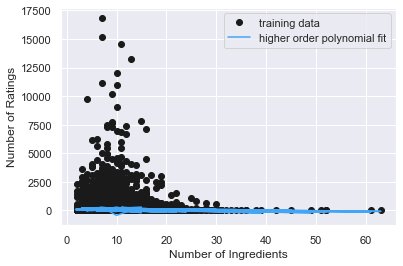

In [153]:
plt.plot(X['Ingredients'], y, 'o', color='k', label='training data')
plt.plot(X['Ingredients'], y_pred, color='#42a5f5ff', label='higher order polynomial fit')
plt.xlabel('Number of Ingredients')
plt.ylabel('Number of Ratings')
plt.legend();

In [157]:
metrics.r2_score(y,y_pred)

0.0035309860794470183

Text(0, 0.5, 'Number of Ratings')

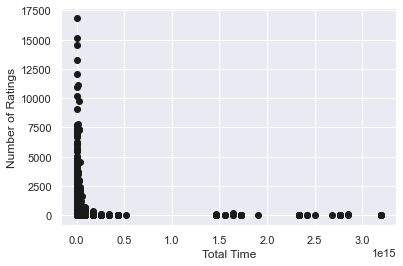

In [185]:
plt.plot(df2['Total Time'], y, 'o', color='k', label='training data')
plt.xlabel('Total Time')
plt.ylabel('Number of Ratings')

In [186]:
df2['Total Time']

0       0 days 02:50:00
1       0 days 00:35:00
2       3 days 00:00:00
3       0 days 01:15:00
4       0 days 01:15:00
              ...      
27080   0 days 01:30:00
27081   0 days 00:45:00
27082   0 days 00:35:00
27083   0 days 01:10:00
27084   0 days 02:00:00
Name: Total Time, Length: 26994, dtype: timedelta64[ns]

0      7
1     87
2    122
4    293
5     19
Name: Number of Ratings, dtype: int64


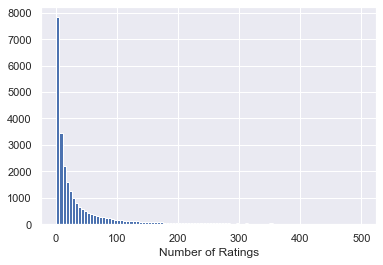

In [201]:
y = y[y<500]
plt.hist(y,100)
plt.xlabel('Number of Ratings')
print(y.head())